<span style= "color: blue">

## **_Part III: Additional feature engineering using additional datasets_**


<span style="color:blue">

**_Overall objective_**:</span> To predict loans at risk of becoming past due or defaulting using Home Credit Group Kaggle dataset

<span style="color:blue">
    
**_Objectives for Notebook 03_**:</span>
* Strategically select priority datasets (besides main dataset _train_application_) for new feature extraction
* Create new features from selected datasets
* Fit and compare:
  - Best model from _application_train_ (main dataset)
  - Best model + new features from other tables
  - Reduced model with features identified via feature importances
* Error analysis and threshhold optimisation

<span style= "color: blue">
  
**_Summary of models attempted:_**</span>  

|Model features | Source datasets |# of features|AUC_ROC|
|:----|:----:|:----:|:----:|
|(1) Model (b) from Notebook 02 | _application_train_ | 77 | .7420 |
|(2) Model (b) + six new features | _application_train_ + _instalments_payments_ + _previous_application_ | 83 | .8185 |
|(3) Features from model (2) with feature importance > 0 | _application_train_ | 29 | .8105 |
|     **Final model**: Model (3)| |  |  |

**Final model features**: 'kids', 'phone_accessibility', 'nbr_late_pymnts', 'years_beginexpluatation_medi',
 'doc3', 'obs_60_cnt_social_circle', 'totalarea_mode', 'credit_inq_yr', 'family_size', 'nbr_prevapps', 'time_applied',
 'income', 'days_since_last_id_change', 'nbr_inst_pymnts', 'job_age_d', 'prop_late_pymnts', 'avg_days_paid_early',
 'days_paid_early', 'annuity_to_income_ratio', 'pop_density', 'credit2income', 'days_last_phone_change', 'id_age_d',
 'registration_age_d', 'annuity', 'age_d', 'goods', 'score_2', 'score_3'


In [1]:
from utils.libraries02_03 import *

from utils.functions import (
    find_duplicates,
    downsize_dtypes,
    process_dataset,
    split_val_test,
    ClampOutliersTransformer,
    create_preprocessing_pipeline,
)

End of utils module


<span style= "color: blue">

#### **_3.1 Entity Relationship Diagram_**</span> 

* For convenience, here is the diagram showing the relationship between the datasets, and [here](https://www.kaggle.com/c/home-credit-default-risk/data) is a link to feature definitions
  

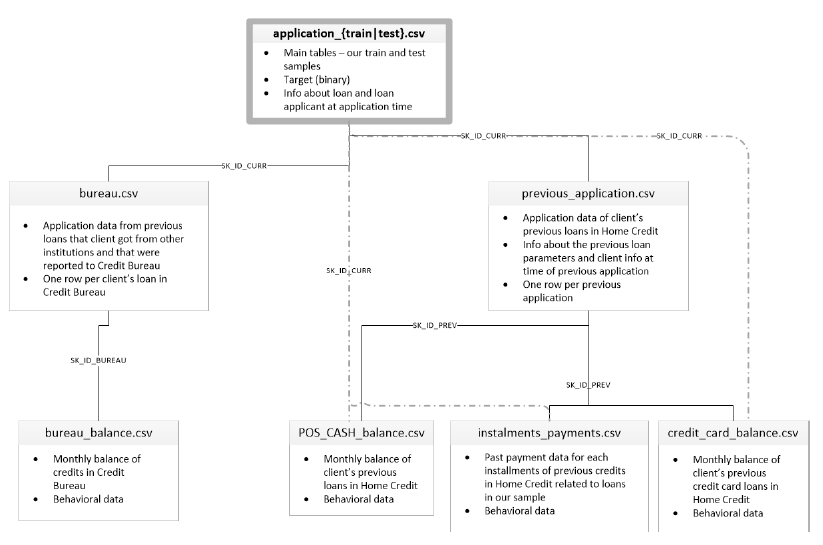

In [2]:
Image("viz/ER diagramme.png")

<span style= "color: blue">
    
#### **_Which of the six datasets/tables besides application_train could we prioritise to create new features?_**</span>
* The four tables on the right refer to applicant data on previous applications and loans with the Home Credit Group 
* The two tables on the left refer data on the same applicants with respect to their loans with other financial institutions
* There are two main types of loans: cash loans or point of sales loans (_POS_CASH_balance_) and revolving loans (_credit_card_balance_).
* _installments_payments.csv_ contains data on both types of loans

<span style= "color: blue">

**Strategy**:</span>
* Prioritise tables associated with Home Credit Group loans, since data are sourced from Home Credit Group so they were likely collected and managed in the same manner (ie. data reliability, quality)
* Select two tables for creating new features:
  - _instalments_payments_ table, since it contains data on both types of loans
  - _previous_applications_ table, since it should be easy to create a simple feature on the number of previous applications corresponding to each current loan applicant

In [3]:
# Format settings
%load_ext jupyter_black
# %reload_ext jupyter_black
pd.options.display.float_format = "{:,.2f}".format

<span style= "color: blue">

### **_3.2 Create five (5) features from 'instalments_payments' table_**

* #### **_Load application_train (or just train) dataset and create a list of the IDs of current loans (SK_ID_CURR)_** </span>
* Since we will create new features, we will load the original _application_train_ dataset again and then split it after the new features are added. 
* The train dataset will be the main dataset used for modelling (suffixes used for preprocessing versions)
* We will be engineering features from a couple of other tables so we will be merging them to this main 

In [4]:
train0 = joblib.load("data/train_features_N01.joblib")
train0.head()

,target,contract_type,gender,car,realty,kids,income,credit_loan,annuity,goods,...,credit_inq_mth,credit_inq_qtr,credit_inq_yr,credit_utilization_ratio,credit2income,annuity_to_income_ratio,days_since_last_id_change,family_size,phone_accessibility,recent_credit_inquiries
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.00,Cash loans,M,N,Y,0.00,"202,500.00","406,597.50","24,700.50","351,000.00",...,0.00,0.00,1.00,2.01,1.73,0.12,"1,483.00",1.00,3.00,0.00
100003,0.00,Cash loans,F,N,N,0.00,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",...,0.00,0.00,0.00,4.79,4.18,0.13,-897.00,2.00,3.00,0.00
100004,0.00,Revolving loans,M,Y,Y,0.00,"67,500.00","135,000.00","6,750.00","135,000.00",...,0.00,0.00,0.00,2.00,2.00,0.10,"2,306.00",1.00,3.00,0.00
100006,0.00,Cash loans,F,N,Y,0.00,"135,000.00","312,682.50","29,686.50","297,000.00",...,NaN,NaN,NaN,2.32,2.20,0.22,-602.00,2.00,2.00,0.00
100007,0.00,Cash loans,M,N,Y,0.00,"121,500.00","513,000.00","21,865.50","513,000.00",...,0.00,0.00,0.00,4.22,4.22,0.18,420.00,1.00,2.00,0.00


In [5]:
train0.shape

(307511, 128)

In [6]:
id_lst = list(train0.index)
len(id_lst)

307511

<span style= "color: blue">

* #### **_Load data for previous Home Credit installment payments; check for duplicates_**

In [7]:
dups = find_duplicates("data/installments_payments.csv", chunksize=10000, index_col=[0])
dups

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT


In [8]:
installments = pd.read_csv("data/installments_payments.csv")

In [9]:
installments.shape

(13605401, 8)

<span style= "color: blue">

* #### **_Restrict data on previous Home Credit installment payments to data from current loan applicants_**

In [10]:
install0 = installments[installments["SK_ID_CURR"].isin(id_lst)]
install0.shape
install0.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.00,6,"-1,180.00","-1,187.00","6,948.36","6,948.36"
1,1330831,151639,0.00,34,"-2,156.00","-2,156.00","1,716.53","1,716.53"
2,2085231,193053,2.00,1,-63.00,-63.00,"25,425.00","25,425.00"
3,2452527,199697,1.00,3,"-2,418.00","-2,426.00","24,350.13","24,350.13"
4,2714724,167756,1.00,2,"-1,383.00","-1,366.00","2,165.04","2,160.59"


<span style= "color: blue">

* #### **_Create new installment-level features:_**</span>
For each installment payment:
  * (1) calculate number of days that installments were paid early (ie. _negative numbers are late payments_) and
  * (2) identify late payments

**Definitions from data dictionary:**
  - **DAYS_INSTALLMENT**: When the installment of previous credit was supposed to be paid (relative to application date of current loan)
  - **DAYS_ENTRY_PAYMENT**: When was the installments of previous credit paid actually (relative to application date of current loan)
  - **SK_ID_PREV**: ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)


In [11]:
install0["paid_early_d"] = install0["DAYS_INSTALMENT"] - install0["DAYS_ENTRY_PAYMENT"]
install0["paid_late01"] = 0
install0.loc[install0["paid_early_d"] < 0, "paid_late01"] = 1

In [12]:
install1 = install0.set_index("SK_ID_PREV")
install1.columns

Index(['SK_ID_CURR', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER',
       'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT',
       'AMT_PAYMENT', 'paid_early_d', 'paid_late01'],
      dtype='object')

<span style= "color: blue">

* #### **_Aggregate new features across historical installments for each current application_**</span>

Now create the corresponding aggregated features, **_aggregating Home Credit Group payment timeliness data of previous loans corresponding to each current loan application_**, including: 
* total number of days that installments were paid early (ie. negative numbers mean number of days payment was late)
* average number of days that installments were paid early 
* total number of installment payments 
* total number of late payments 
* average number of late payments 

In [13]:
%%time
agg_list = {
    "paid_early_d": ["sum", "mean", "count"],
    "paid_late01": ["sum", "mean"],
}

install_agg = install1.groupby("SK_ID_CURR").agg(agg_list)
install_agg.shape, install_agg.head()

CPU times: total: 1.64 s
Wall time: 2.39 s


((291643, 5),
            paid_early_d             paid_late01     
                     sum  mean count         sum mean
 SK_ID_CURR                                          
 100002           388.00 20.42    19           0 0.00
 100003           179.00  7.16    25           0 0.00
 100004            23.00  7.67     3           0 0.00
 100006           310.00 19.38    16           0 0.00
 100007           240.00  3.64    66          16 0.24)

In [14]:
new_names = {
    ("paid_early_d", "sum"): "days_paid_early",
    ("paid_early_d", "mean"): "avg_days_paid_early",
    ("paid_early_d", "count"): "nbr_inst_pymnts",
    ("paid_late01", "sum"): "nbr_late_pymnts",
    ("paid_late01", "mean"): "prop_late_pymnts",
}

install_agg.columns = install_agg.columns.map(new_names)

In [15]:
install_agg.head()

,days_paid_early,avg_days_paid_early,nbr_inst_pymnts,nbr_late_pymnts,prop_late_pymnts
SK_ID_CURR,,,,,
100002,388.00,20.42,19,0,0.00
100003,179.00,7.16,25,0,0.00
100004,23.00,7.67,3,0,0.00
100006,310.00,19.38,16,0,0.00
100007,240.00,3.64,66,16,0.24


In [16]:
train1 = train0.merge(install_agg, how="left", left_index=True, right_index=True)
train1.shape

(307511, 133)

<span style= "color: blue">

### **_3.3 Create one feature from previous_application table_**</span>

* Number of previous applications corresponding to each current application

* Each previous application has a unique ID (ie. SK_ID_PREV) corresponding to current application ID (ie. SK_ID_CURR), so just need to aggregate these by current ID.
* First step, however is to limit the _previous_application_ table to those rows of data corresponding to the list of application IDs in _application_train_.

In [17]:
train1.shape

(307511, 133)

In [18]:
prev_id = pd.read_csv(
    "data/previous_application.csv",
    usecols=["SK_ID_CURR", "SK_ID_PREV"],
)

In [19]:
id_key0 = prev_id[prev_id["SK_ID_CURR"].isin(id_lst)]

In [20]:
%%time
prev_apps = id_key0.groupby("SK_ID_CURR").agg("count")
prev_apps1 = prev_apps.rename(columns={"SK_ID_PREV": "nbr_prevapps"}).copy(deep=True)
prev_apps1.shape, prev_apps1.head()

CPU times: total: 141 ms
Wall time: 171 ms


((291057, 1),
             nbr_prevapps
 SK_ID_CURR              
 100002                 1
 100003                 3
 100004                 1
 100006                 9
 100007                 6)

<span style= "color: blue">

#### **_Insight_** </span>

* Number of current application IDs (ie rows of SK_ID_CURR) in _previous_application_ is 174683, which is less than 184506 in the main table (ie. _application_train_) --as expected!

In [21]:
train2 = train1.merge(prev_apps1, how="left", left_index=True, right_index=True)
joblib.dump(train2, "data/train2.joblib")
train2.head()

,target,contract_type,gender,car,realty,kids,income,credit_loan,annuity,goods,...,days_since_last_id_change,family_size,phone_accessibility,recent_credit_inquiries,days_paid_early,avg_days_paid_early,nbr_inst_pymnts,nbr_late_pymnts,prop_late_pymnts,nbr_prevapps
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.00,Cash loans,M,N,Y,0.00,"202,500.00","406,597.50","24,700.50","351,000.00",...,"1,483.00",1.00,3.00,0.00,388.00,20.42,19.00,0.00,0.00,1.00
100003,0.00,Cash loans,F,N,N,0.00,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",...,-897.00,2.00,3.00,0.00,179.00,7.16,25.00,0.00,0.00,3.00
100004,0.00,Revolving loans,M,Y,Y,0.00,"67,500.00","135,000.00","6,750.00","135,000.00",...,"2,306.00",1.00,3.00,0.00,23.00,7.67,3.00,0.00,0.00,1.00
100006,0.00,Cash loans,F,N,Y,0.00,"135,000.00","312,682.50","29,686.50","297,000.00",...,-602.00,2.00,2.00,0.00,310.00,19.38,16.00,0.00,0.00,9.00
100007,0.00,Cash loans,M,N,Y,0.00,"121,500.00","513,000.00","21,865.50","513,000.00",...,420.00,1.00,2.00,0.00,240.00,3.64,66.00,16.00,0.24,6.00


In [22]:
train2.shape

(307511, 134)

<span style= "color: blue">

#### **_Summary_** </span>

* The main _application_train_ dataset was split into training, validation and test datasets in Notebook 01 (named _train_, _val_ and _test_).
* To _train_ we added 5 new features from the _instalments_payments_ table and one new feature from _previous_application_ table, naming it _train2_. 

<span style= "color: blue">
    
### **_3.4 Split data_**</span>

In [23]:
X = train2.drop(columns=["target"], axis=1)
y = train2[["target"]]

X_train, X_val, X_test, y_train, y_val, y_test = split_val_test(
    X, y, train_size=0.6, val_size=0.2, test_size=0.2
)

train = X_train.merge(y_train, left_index=True, right_index=True)
val = X_val.merge(y_val, left_index=True, right_index=True)
test = X_test.merge(y_test, left_index=True, right_index=True)

In [24]:
train.shape, val.shape, test.shape

((184506, 134), (61502, 134), (61503, 134))

In [25]:
new_vars_lst = [
    "days_paid_early",
    "avg_days_paid_early",
    "nbr_inst_pymnts",
    "nbr_late_pymnts",
    "prop_late_pymnts",
    "nbr_prevapps",
]

<span style= "color: blue">
    
* #### **_Add new variables to best model from Notebook 02_**

In [26]:
features_smartcorr = joblib.load("data/features_smartcorr_lst.joblib")
features_smartcorr3 = features_smartcorr + new_vars_lst
len(features_smartcorr3)
joblib.dump(features_smartcorr3, "data/features_smartcorr3")

['data/features_smartcorr3']

<span style= "color: blue">
    
### **_3.5 Fit model_**

In [27]:
selected_features = features_smartcorr3
X_train, y_train, X_train_num, X_train_num_lst, X_train_cat, X_train_cat_lst, train = (
    process_dataset(train2, "target", 5, 0.8, selected_features)
)
train.shape

(119160, 84)

In [28]:
X_val, y_val, _, _, _, _, val = process_dataset(
    val, "target", 5, 0.8, selected_features
)
val.shape

(24084, 84)

In [29]:
%%time

pp_transformer, class_weights = create_preprocessing_pipeline(
    X_train_num_lst, X_train_cat_lst, y_train
)

cb_estimator = CatBoostClassifier(
    loss_function="Logloss",
    class_weights=class_weights,
    class_names=[0, 1],
    verbose=100,
    random_seed=42,
)

cb_pipe = Pipeline(
    [
        ("pp_transformer", pp_transformer),
        ("cb_estimator", cb_estimator),
    ]
)
cb_pipe.fit(X_train, y_train)
y_pred = cb_pipe.predict(X_val)

Learning rate set to 0.079331
0:	learn: 0.6821101	total: 203ms	remaining: 3m 22s
100:	learn: 0.5913443	total: 7.58s	remaining: 1m 7s
200:	learn: 0.5778387	total: 16.9s	remaining: 1m 7s
300:	learn: 0.5648559	total: 24.5s	remaining: 57s
400:	learn: 0.5535049	total: 35.9s	remaining: 53.6s
500:	learn: 0.5429764	total: 45.2s	remaining: 45s
600:	learn: 0.5326420	total: 52.6s	remaining: 34.9s
700:	learn: 0.5232929	total: 59.6s	remaining: 25.4s
800:	learn: 0.5142648	total: 1m 7s	remaining: 16.7s
900:	learn: 0.5059014	total: 1m 14s	remaining: 8.19s
999:	learn: 0.4980724	total: 1m 22s	remaining: 0us
CPU times: total: 2min 38s
Wall time: 1min 25s


In [30]:
joblib.dump(cb_pipe, "data/cb_pipe_96f86.joblib")

['data/cb_pipe_96f86.joblib']

In [31]:
report = classification_report(y_val, y_pred)
print(report)

roc_auc = roc_auc_score(y_val, cb_pipe.predict_proba(X_val)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")

              precision    recall  f1-score   support

         0.0       0.94      0.74      0.83     20070
         1.0       0.36      0.75      0.49      4014

    accuracy                           0.74     24084
   macro avg       0.65      0.74      0.66     24084
weighted avg       0.84      0.74      0.77     24084

ROC-AUC Score: 0.8185


<span style= "color: blue">
    
* ##### **_Feature importances_**

In [32]:
importances = cb_estimator.get_feature_importance(type="PredictionValuesChange")
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()
features_mask = feature_importances > 0
feature_importances_tbl = feature_importances[features_mask].sort_values(
    ascending=False
)
feature_importances_tbl

score_3                        9.60
score_2                        9.51
goods                          6.43
age_d                          6.41
annuity                        5.45
registration_age_d             4.63
id_age_d                       4.61
days_last_phone_change         4.32
credit2income                  4.19
pop_density                    4.15
annuity_to_income_ratio        4.01
days_paid_early                3.82
avg_days_paid_early            3.81
prop_late_pymnts               3.58
job_age_d                      3.55
nbr_inst_pymnts                3.45
days_since_last_id_change      2.76
income                         2.72
time_applied                   2.21
nbr_prevapps                   1.88
family_size                    1.53
credit_inq_yr                  1.46
totalarea_mode                 1.29
obs_60_cnt_social_circle       1.18
doc3                           0.99
years_beginexpluatation_medi   0.95
nbr_late_pymnts                0.70
phone_accessibility         

In [33]:
feature_imp_hi = pd.Series(feature_importances[features_mask])
feature_imp_hi_lst = feature_imp_hi.index.to_list()
feature_imp_hi_lst_y = feature_imp_hi_lst + ["target"]
len(feature_imp_hi_lst_y)

30

Text(0, 0.5, 'Features')

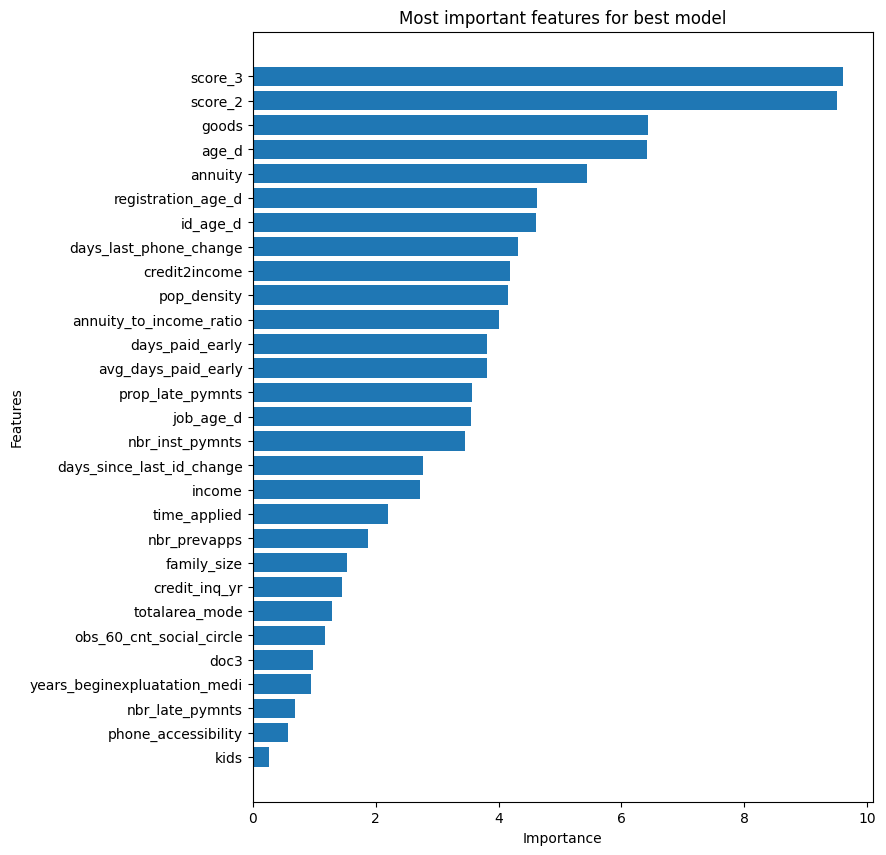

In [34]:
plt.figure(figsize=(8, 10))
plt.barh(feature_imp_hi.index, feature_imp_hi.values)
plt.title("Most important features for model")
plt.xlabel("Importance")
plt.ylabel("Features")

<span style= "color: blue">
    
#### **_Fit reduced model_**

In [35]:
# fmt: off
len(feature_imp_hi_lst_y), feature_imp_hi_lst
joblib.dump(feature_imp_hi_lst_y, "data/feature_imp_hi_lst_y.joblib")

['data/feature_imp_hi_lst_y.joblib']

In [36]:
selected_features = feature_imp_hi_lst_y
X_train, y_train, X_train_num, X_train_num_lst, X_train_cat, X_train_cat_lst, train = (
    process_dataset(train2, "target", 5, 0.7, selected_features)
)
train.shape

(104268, 30)

In [37]:
X_val, y_val, _, _, _, _, val = process_dataset(
    val, "target", 3, 0.9, selected_features
)
val.shape

(14452, 30)

In [38]:
%%time
pp_transformer, class_weights = create_preprocessing_pipeline(
    X_train_num_lst, X_train_cat_lst, y_train
)

cb_estimator = CatBoostClassifier(
    loss_function="Logloss",
    class_weights=class_weights,
    class_names=[0, 1],
    verbose=100,
    random_seed=42,
)

cb_pipe = Pipeline(
    [
        ("pp_transformer", pp_transformer),
        ("cb_estimator", cb_estimator),
    ]
)
cb_pipe.fit(X_train, y_train)
y_pred = cb_pipe.predict(X_val)

joblib.dump(pp_transformer, "data/pp_transformer.joblib")
joblib.dump(cb_estimator, "data/cb_estimator.joblib")

Learning rate set to 0.074935
0:	learn: 0.6827437	total: 67.5ms	remaining: 1m 7s
100:	learn: 0.5908116	total: 7.29s	remaining: 1m 4s
200:	learn: 0.5767084	total: 13.6s	remaining: 54s
300:	learn: 0.5625155	total: 20.4s	remaining: 47.3s
400:	learn: 0.5500163	total: 27.1s	remaining: 40.5s
500:	learn: 0.5385384	total: 33.9s	remaining: 33.7s
600:	learn: 0.5278988	total: 40.6s	remaining: 27s
700:	learn: 0.5176421	total: 47.4s	remaining: 20.2s
800:	learn: 0.5080764	total: 54s	remaining: 13.4s
900:	learn: 0.4991085	total: 1m	remaining: 6.66s
999:	learn: 0.4905380	total: 1m 7s	remaining: 0us
CPU times: total: 1min 50s
Wall time: 1min 9s


['data/cb_estimator.joblib']

In [39]:
X_train_tr = pp_transformer.fit_transform(X_train, y_train)

In [40]:
joblib.dump(cb_pipe, "data/cb_pipe_43f86.joblib")

['data/cb_pipe_43f86.joblib']

In [41]:
report = classification_report(y_val, y_pred)
print(report)

roc_auc = roc_auc_score(y_val, cb_pipe.predict_proba(X_val)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")

              precision    recall  f1-score   support

         0.0       0.89      0.75      0.81     10839
         1.0       0.49      0.73      0.59      3613

    accuracy                           0.74     14452
   macro avg       0.69      0.74      0.70     14452
weighted avg       0.79      0.74      0.76     14452

ROC-AUC Score: 0.8133


<span style= "color: blue">

#### **_Hyperparameter tuning_**

In [42]:
logging.basicConfig(filename="optuna.log", level=logging.INFO)

In [ ]:
%%time
%%capture

def objective(trial: optuna.Trial):
    iterations = trial.suggest_int("iterations", 100, 400)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 0.1)
    depth = trial.suggest_int("depth", 1, 10)
    l2_leaf_reg = trial.suggest_loguniform("l2_leaf_reg", 1e-8, 1.0)

    params = {
        "iterations": iterations,
        "learning_rate": learning_rate,
        "depth": depth,
        "l2_leaf_reg": l2_leaf_reg,
    }

    cb_pipe = Pipeline(
        [
            ("pp_transformer", pp_transformer),
            (
                "cb_estimator",
                CatBoostClassifier(
                    **params,
                    loss_function="Logloss",
                    class_weights=class_weights,
                    class_names=[0, 1],
                    verbose=100,
                    random_seed=42,
                ),
            ),
        ]
    )
    best_score = -np.inf
    best_params = None

    for i in range(10):
        cb_pipe.fit(X_train, y_train)
        y_pred = cb_pipe.predict(X_val)
        auc_roc = roc_auc_score(y_val, y_pred)

        if auc_roc > best_score:
            best_score = auc_roc
            best_params = params.copy()

        if i >= 20:
            break

    return best_score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=-1)


In [95]:
best_params = study.best_params
print("Best hyperparameters:", best_params)

Best hyperparameters: {'iterations': 373, 'learning_rate': 0.07094535510406666, 'depth': 10, 'l2_leaf_reg': 8.996881401470376e-05}


In [96]:
best_score = study.best_value
print(f"Best score: {best_score}")

Best score: 0.8286742319402159


In [97]:
joblib.dump(study, "optuna_study.joblib")

['optuna_study.joblib']

In [98]:
params = {
    "iterations": best_params["iterations"],
    "learning_rate": best_params["learning_rate"],
    "depth": best_params["depth"],
    "l2_leaf_reg": best_params["l2_leaf_reg"],
}

final_pipe = Pipeline(
    [
        ("pp_transformer", pp_transformer),
        (
            "cb_estimator",
            CatBoostClassifier(
                **params,
                loss_function="Logloss",
                class_weights=class_weights,
                class_names=[0, 1],
                verbose=10000,
                random_seed=42,
            ),
        ),
    ]
)

final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)

Object info sizes: 104268 29
0:	learn: 0.6810768	total: 196ms	remaining: 1m 13s
372:	learn: 0.2610668	total: 1m 48s	remaining: 0us
Object info sizes: 61503 29


In [99]:
report = classification_report(
    y_test, y_pred, target_names=["Payments on time", "Past due/Default"]
)
print(report)

                  precision    recall  f1-score   support

Payments on time       0.98      0.85      0.91     56554
Past due/Default       0.32      0.80      0.45      4949

        accuracy                           0.84     61503
       macro avg       0.65      0.83      0.68     61503
    weighted avg       0.93      0.84      0.87     61503



In [100]:
roc_auc = roc_auc_score(y_test, final_pipe.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")

Object info sizes: 61503 29
ROC-AUC Score: 0.8909


<span style= "color: blue">

#### **_Insight_** </span>

* The ROC-AUC score from fitting the model on testing data confirms that the model works on unseen data. It also compare favourably with the [winning Kaggle competition score of .80570](https://www.kaggle.com/c/home-credit-default-risk/leaderboard)
* The next step is to assess whether this can be improved upon by adjusting the threshold, which we suspect may be the case as the data are imbalanced. 

<span style= "color: blue">

#### **_Threshhold optimisation_**</span>


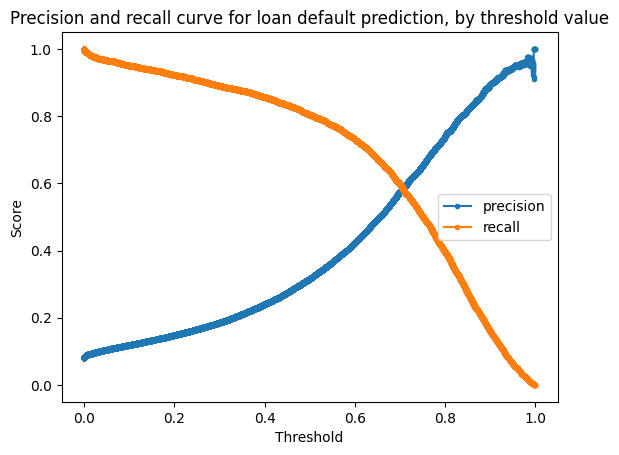

In [112]:
plt.plot(thresholds, precision[:-1], marker=".", label="precision")
plt.plot(thresholds, recall[:-1], marker=".", label="recall")
f1_scores = [f1_score(y_test01_np, y_pred01) for t in thresholds]
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title(
    "Precision and recall curve for loan default prediction, by threshold value",
    fontsize=12,
)
plt.show()

<span style= "color: blue">

#### **_Final Model_**

In [117]:
y_pred_proba = final_pipe.predict_proba(X_test)
y_pred_proba_1 = y_pred_proba[:, 1]

threshold = 0.73
y_pred01 = (y_pred_proba_1 > threshold).astype(int)
y_test01_np = y_test.to_numpy().flatten()

print(classification_report(y_test01_np, y_pred01))
roc_auc = roc_auc_score(y_test, final_pipe.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")

Object info sizes: 61503 29
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     56554
         1.0       0.62      0.54      0.58      4949

    accuracy                           0.94     61503
   macro avg       0.79      0.76      0.77     61503
weighted avg       0.93      0.94      0.93     61503

Object info sizes: 61503 29
ROC-AUC Score: 0.8909


* ##### Changing the threshold did not appear to change model performance

Object info sizes: 61503 29
Object info sizes: 61503 29


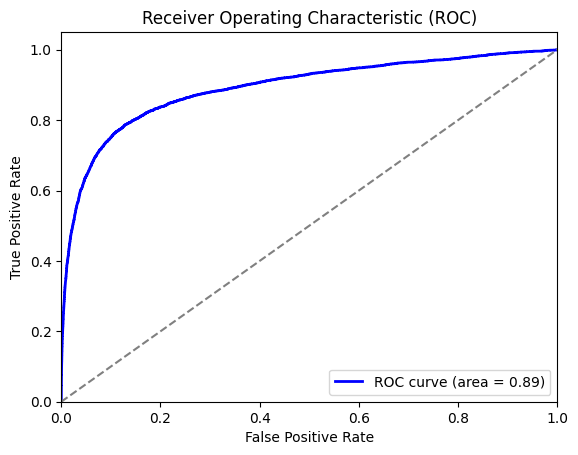

In [115]:
roc_auc = metrics.roc_auc_score(y_test, final_pipe.predict_proba(X_test)[:, 1])
fpr, tpr, _ = metrics.roc_curve(y_test, final_pipe.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

Object info sizes: 61503 29


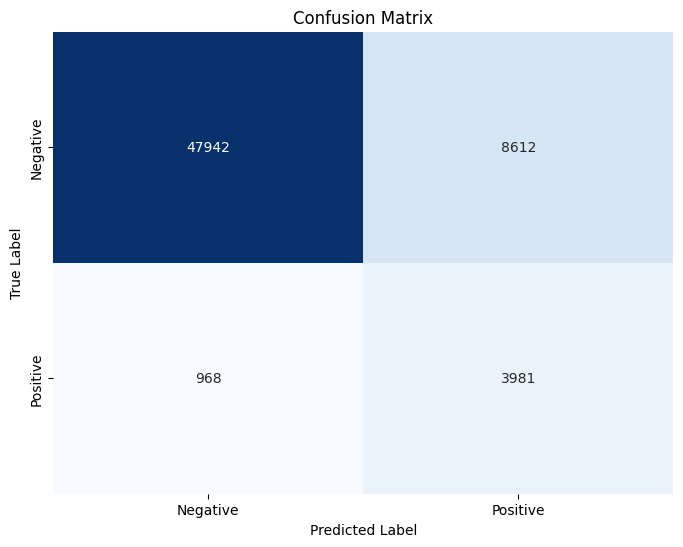

In [116]:
y_pred = final_pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()